In [2]:
import pandas as pd
from pointpats.geometry import(TREE_TYPES)
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import PointPattern
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
import pandas as pd
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point, Polygon
import glob
import os
import re

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.ht

In [126]:
data = pd.read_pickle('/Users/gocchini/Desktop/paper_3/data/complete_df_paper_3.pkl')

In [127]:
#remember this damn tilde in pandas!! 
data = data[~(data['suspicious'] == 'SUSPICIOUS!')]

# Assign coords to firms based on postcode centroids

In [17]:
all_postcodes_centroids= pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')
all_postcodes_centroids = all_postcodes_centroids[['pcd', 'lat', 'long']]

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_89886/3818275856.py:1: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  all_postcodes_centroids= pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')


In [128]:
data_with_coords = data.merge(all_postcodes_centroids, left_on = 'R/O Full Postcode.1_x', right_on = 'pcd', how = 'left')

In [129]:
data_with_coords

,url,status,text,added_urls,actual_url,Unnamed: 0_x_x,Company name,Inactive_x,R/O Full Postcode_x,Primary UK SIC (2007) code_x,...,postcode_x,Unnamed: 0_y_x,CSH - Name_x,PSC - Name_x,natural_entity_finder_x,text_postcodes,suspicious,pcd,lat,long
0,http://www.morganstanley.com,True,\n\n\n\nMorgan Stanley | Global Leader in Fina...,"[http://www.morganstanley.com/, http://www.mor...",www.morganstanley.com,146.0,MORGAN STANLEY GROUP (EUROPE),No,E14 4AD,70100.0,...,E14 4AD,59997.0,MORGAN STANLEY,Morgan Stanley International Limited,natural person,[],None,E14 4AD,51.502986,-0.022088
1,http://www.rrmedia.com,True,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[http://www.rrmedia.com#main-content, http://w...",www.rrmedia.com,393.0,VDMS ACTON LIMITED,No,W10 6QN,82990.0,...,W10 6QN,60147.0,VISUAL DATA MEDIA SERVICES LLC,Visual Data Media Services Limited,natural person,[],None,W10 6QN,51.519467,-0.225561
2,http://fortunefinancialservices.com,True,\n\n\n\n\nHome\nWelcome to Fortune Financial S...,"[http://fortunefinancialservices.com/about-us,...",fortunefinancialservices.com,728.0,FORTUNE FINANCIAL SERVICES LIMITED,No,NW4 4HA,66220.0,...,NW4 4HA,60342.0,NaN,Mr Premji Devraj Halai,natural person,[],None,NW4 4HA,51.586165,-0.234599
3,http://www.ashtonwalker.com,True,\n\n\n\nHOME\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[http://www.ashtonwalker.com/, http://www.asht...",www.ashtonwalker.com,795.0,ASHTON WALKER LIMITED,No,TW1 4TQ,74902.0,...,TW1 4TQ,60377.0,NaN,Mrs Karen Elizabeth Surtees,natural person,[],None,TW1 4TQ,51.433613,-0.333179
4,http://www.htmtradeco.com,True,\n\nHTM TRADECO LTD - European Distribution of...,"[http://www.htmtradeco.commain.htm, http://www...",www.htmtradeco.com,822.0,H.T.M. TRADECO LIMITED,No,EN3 7SY,82990.0,...,EN3 7SY,60392.0,MR ABOAL HASSAN TABATABAEE MADANI,Mr Aboal Hassan Tabatabaee Madani,natural person,[EN3 7SY],ok,EN3 7SY,51.648347,-0.032044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23044,http://www.intlmedicalplacement.com,True,\n\n\n\n\n\n\n\n\n\n\n\n\r\n\tInternational Me...,"[https://www.intlmedicalplacement.com/, http:/...",www.intlmedicalplacement.com,69332.0,TSVETKOV LTD,No,UB5 6EE,96090.0,...,UB5 6EE,12849.0,NaN,Mr Hristo Nikolov Tsvetkov,natural person,[],None,UB5 6EE,51.532862,-0.385310
23045,http://www.ybsuk.co.uk,True,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[https://www.ybsuk.co.uk, https://www.ybsuk.co...",www.ybsuk.co.uk,69940.0,YOUR BUSINESS SERVICES (UK) LTD,No,E17 5PX,69202.0,...,E17 5PX,13126.0,MRS DAGMAR KLONGOVA,Mrs Dagmar Klongova,natural person,[],None,E17 5PX,51.597912,-0.040839
23046,http://londonrubbishltd.co.uk,True,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[http://londonrubbishltd.co.uk#content, http:/...",londonrubbishltd.co.uk,70246.0,LONDON RUBBISH LTD,No,TW8 8HY,82990.0,...,TW8 8HY,13271.0,MR MACIEJ SOBICZEWSKI,Mr Maciej Sobiczewski,natural person,[TW8 8HY],ok,TW8 8HY,51.481435,-0.313103
23047,http://www.bell-integrated.co.uk,True,"\n\n\n\n\n\n\n\n\n\n\nBranding, Creative, Digi...","[https://www.bell-integrated.co.uk/, https://w...",www.bell-integrated.co.uk,72236.0,BELL INTEGRATED COMMUNICATIONS LIMITED,No,W1T 1PT,74100.0,...,W1T 1PT,14296.0,MARTECH CAPITAL SAS,Mr Stanislas Di Vittorio,natural person,"[OP26Ou, W1T 1PT]",None,W1T 1PT,51.518147,-0.135788


# Delete sus postcodes (>10 addresses)

In [130]:
postcodes_instances = data_with_coords['R/O Full Postcode.1_x'].value_counts()
big_postcodes_instances = pd.DataFrame(postcodes_instances)
big_postcodes_instances = big_postcodes_instances.loc[big_postcodes_instances['R/O Full Postcode.1_x'] >=10]
big_postcodes_instances = big_postcodes_instances.index.tolist()

In [131]:
len(big_postcodes_instances)

221

In [112]:
len(big_postcodes_instances)

402

def delete_sus(df, big_postcode):
    if df['R/O Full Postcode.1_x'] == big_postcode:
        df['too_big'] == True
    return df 

In [113]:
#this is exactly the same as isint :) 

def delete_sus(df, postcodes):
    for x in postcodes:
        df.drop(df.index[df['R/O Full Postcode.1_x'] == x], inplace = True)
    return df 

In [132]:
data_non_sus = data_with_coords[~data_with_coords['R/O Full Postcode.1_x'].isin(big_postcodes_instances)]

In [133]:
data_non_sus

,url,status,text,added_urls,actual_url,Unnamed: 0_x_x,Company name,Inactive_x,R/O Full Postcode_x,Primary UK SIC (2007) code_x,...,postcode_x,Unnamed: 0_y_x,CSH - Name_x,PSC - Name_x,natural_entity_finder_x,text_postcodes,suspicious,pcd,lat,long
0,http://www.morganstanley.com,True,\n\n\n\nMorgan Stanley | Global Leader in Fina...,"[http://www.morganstanley.com/, http://www.mor...",www.morganstanley.com,146.0,MORGAN STANLEY GROUP (EUROPE),No,E14 4AD,70100.0,...,E14 4AD,59997.0,MORGAN STANLEY,Morgan Stanley International Limited,natural person,[],None,E14 4AD,51.502986,-0.022088
1,http://www.rrmedia.com,True,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[http://www.rrmedia.com#main-content, http://w...",www.rrmedia.com,393.0,VDMS ACTON LIMITED,No,W10 6QN,82990.0,...,W10 6QN,60147.0,VISUAL DATA MEDIA SERVICES LLC,Visual Data Media Services Limited,natural person,[],None,W10 6QN,51.519467,-0.225561
2,http://fortunefinancialservices.com,True,\n\n\n\n\nHome\nWelcome to Fortune Financial S...,"[http://fortunefinancialservices.com/about-us,...",fortunefinancialservices.com,728.0,FORTUNE FINANCIAL SERVICES LIMITED,No,NW4 4HA,66220.0,...,NW4 4HA,60342.0,NaN,Mr Premji Devraj Halai,natural person,[],None,NW4 4HA,51.586165,-0.234599
3,http://www.ashtonwalker.com,True,\n\n\n\nHOME\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[http://www.ashtonwalker.com/, http://www.asht...",www.ashtonwalker.com,795.0,ASHTON WALKER LIMITED,No,TW1 4TQ,74902.0,...,TW1 4TQ,60377.0,NaN,Mrs Karen Elizabeth Surtees,natural person,[],None,TW1 4TQ,51.433613,-0.333179
4,http://www.htmtradeco.com,True,\n\nHTM TRADECO LTD - European Distribution of...,"[http://www.htmtradeco.commain.htm, http://www...",www.htmtradeco.com,822.0,H.T.M. TRADECO LIMITED,No,EN3 7SY,82990.0,...,EN3 7SY,60392.0,MR ABOAL HASSAN TABATABAEE MADANI,Mr Aboal Hassan Tabatabaee Madani,natural person,[EN3 7SY],ok,EN3 7SY,51.648347,-0.032044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23044,http://www.intlmedicalplacement.com,True,\n\n\n\n\n\n\n\n\n\n\n\n\r\n\tInternational Me...,"[https://www.intlmedicalplacement.com/, http:/...",www.intlmedicalplacement.com,69332.0,TSVETKOV LTD,No,UB5 6EE,96090.0,...,UB5 6EE,12849.0,NaN,Mr Hristo Nikolov Tsvetkov,natural person,[],None,UB5 6EE,51.532862,-0.385310
23045,http://www.ybsuk.co.uk,True,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[https://www.ybsuk.co.uk, https://www.ybsuk.co...",www.ybsuk.co.uk,69940.0,YOUR BUSINESS SERVICES (UK) LTD,No,E17 5PX,69202.0,...,E17 5PX,13126.0,MRS DAGMAR KLONGOVA,Mrs Dagmar Klongova,natural person,[],None,E17 5PX,51.597912,-0.040839
23046,http://londonrubbishltd.co.uk,True,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"[http://londonrubbishltd.co.uk#content, http:/...",londonrubbishltd.co.uk,70246.0,LONDON RUBBISH LTD,No,TW8 8HY,82990.0,...,TW8 8HY,13271.0,MR MACIEJ SOBICZEWSKI,Mr Maciej Sobiczewski,natural person,[TW8 8HY],ok,TW8 8HY,51.481435,-0.313103
23047,http://www.bell-integrated.co.uk,True,"\n\n\n\n\n\n\n\n\n\n\nBranding, Creative, Digi...","[https://www.bell-integrated.co.uk/, https://w...",www.bell-integrated.co.uk,72236.0,BELL INTEGRATED COMMUNICATIONS LIMITED,No,W1T 1PT,74100.0,...,W1T 1PT,14296.0,MARTECH CAPITAL SAS,Mr Stanislas Di Vittorio,natural person,"[OP26Ou, W1T 1PT]",None,W1T 1PT,51.518147,-0.135788


In [134]:
data_non_sus.to_pickle('/Users/gocchini/Desktop/paper_3/data/data_non_sus_10.pkl')

In [116]:
coords = data_non_sus[['lat', 'long']]

In [117]:
pts = coords.apply(lambda r: Point(r.long, r.lat), axis=1)

In [118]:
gdb = gpd.GeoDataFrame(coords.assign(geometry=pts), \
                       crs={'init' :'epsg:4326'})

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [119]:
gdb = gdb.to_crs(epsg=27700)

In [120]:
xys = gdb['geometry'].apply(lambda pt: pd.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

In [12]:

london = geopandas.read_file('/Users/gocchini/Desktop/paper_3/data/shapefiles/statistical-gis-boundaries-london/ESRI/MSOA_2004_London_High_Resolution.shp')
#look at it based on LA
london = london.dissolve(by = 'LA_NAME')
london.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_46938/2425647863.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax,


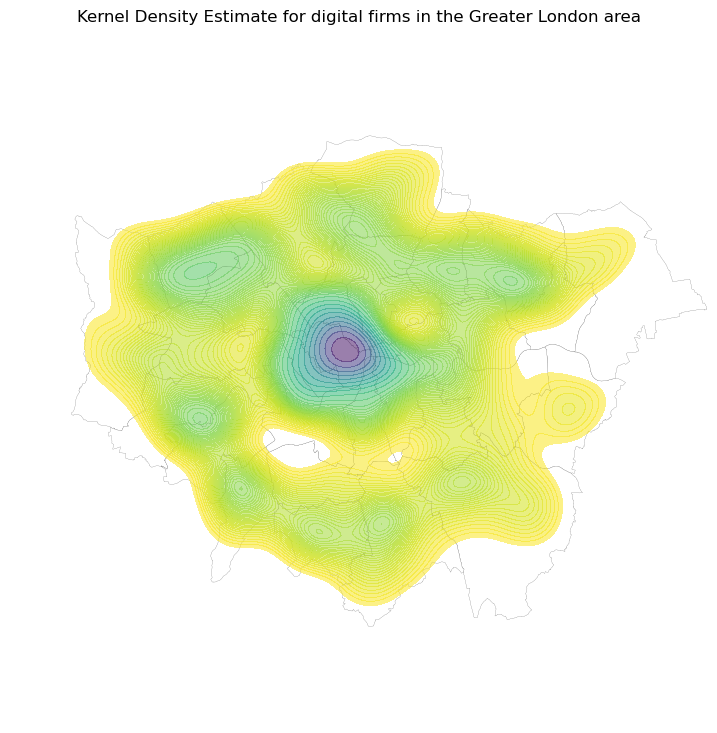

In [122]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Add a base layer with the LSOA geography
london.plot(ax = ax, color='white', edgecolor='black', linewidth=0.1)
# Generate KDE
seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax, 
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Remove axes
ax.set_axis_off()
# Add title
ax.set_title("Kernel Density Estimate for digital firms in the Greater London area")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

# let's do the same for tangibles! :) 
# These data are not checked for suspiciousness though!!! Gotta do that

In [3]:
tangibles_main_shareholder = pd.concat([pd.read_excel(f, 'Results') for f in glob.glob('/Users/gocchini/Desktop/paper_3/data/FAME_TANGIBLES/*.xlsx')], ignore_index = True)

In [5]:
with open ('/Users/gocchini/Desktop/paper_3/data/list-of-salutations-titles-honorifics.txt') as f: 
    lines = f.readlines()
honorifics = [line.strip() for line in lines]

In [6]:
def natural_entity_finder(entity, honorifics):
    if type(entity) != float:
        if any(honorific in entity for honorific in honorifics): 
            return 'natural person'
        else:
            return 'conglomerate'

In [7]:
tangibles_main_shareholder['natural_entity_finder'] = tangibles_main_shareholder.apply(lambda x: natural_entity_finder(x['PSC - Name'], honorifics), axis = 1)
tangibles_main_shareholder = tangibles_main_shareholder.loc[tangibles_main_shareholder['natural_entity_finder'] ==  'natural person']

In [10]:
tangibles_main_shareholder = tangibles_main_shareholder.loc[tangibles_main_shareholder['R/O Full Postcode'].notna()]

In [52]:
# deleting sus postcodes 
postcodes_instances_tan = tangibles_main_shareholder['R/O Full Postcode'].value_counts()
big_postcodes_instances_tan = pd.DataFrame(postcodes_instances_tan)
big_postcodes_instances_tan = big_postcodes_instances_tan.loc[big_postcodes_instances_tan['R/O Full Postcode'] >=10]
big_postcodes_instances_tan = big_postcodes_instances_tan.index.tolist()

In [54]:
tan_non_sus = tangibles_main_shareholder[~tangibles_main_shareholder['R/O Full Postcode'].isin(big_postcodes_instances_tan)]

# make sure data are actually in London

In [91]:
london_postcodes = pd.read_csv('/Users/gocchini/Desktop/paper_3/data/london_postcodes-ons-postcodes-directory-feb22.csv')

In [92]:
london_postcodes = london_postcodes['pcd'].tolist()
tan_non_sus_london =  tan_non_sus[tan_non_sus['R/O Full Postcode'].isin(london_postcodes)]

In [94]:
tan_non_sus

,Unnamed: 0,Company name,R/O Full Postcode,Registered number,Primary UK SIC (2007) code,Number of employees\nLast avail. yr,PSC - Name,natural_entity_finder
5,5.0,NKD LTD,W7 2DG,09653848,82990.0,1,Mrs Harsha Davda,natural person
11,10.0,INTERNATIONAL MEDIA LTD,E1 1JD,09654282,58190.0,NaN,Mr Shoeb Uddin Kabir,natural person
14,13.0,MWJ CONSTRUCTION LTD,W4 1AF,09654446,41201.0,1,Mr Marcin Wojtas,natural person
19,17.0,LITTLE BANANAS BALLOONS LTD.,SE12 9NE,09654506,93290.0,NaN,Miss Julie Marie Oates,natural person
20,18.0,AGILE PROPERTY DEVELOPMENTS LIMITED,SW15 2LD,09654534,41100.0,NaN,Mrs Lynwen Ann Gibbons,natural person
...,...,...,...,...,...,...,...,...
292370,141973.0,MTART AGENCY LTD,W1U 3AP,09652692,90030.0,5,Marine Tanguy,natural person
292371,141974.0,D&D RESTAURANT LTD,N13 4SP,09652699,56101.0,10,Mr Denis Orhanov Aliev,natural person
292373,141976.0,CAMBRIDGE HEATH KEBAB LIMITED,E2 9BU,09652731,56103.0,5,Mr Mehmet Celik,natural person
292374,141977.0,RENEWING THE AFRICAN MINDSET,SE1 9EZ,09652768,96040.0,NaN,Miss Anne Funmi Fatusin,natural person


In [93]:
tan_non_sus_london

,Unnamed: 0,Company name,R/O Full Postcode,Registered number,Primary UK SIC (2007) code,Number of employees\nLast avail. yr,PSC - Name,natural_entity_finder
34,30.0,BEARES PUBLISHING LIMITED,W1G 8HX,09655090,58110.0,2,Mr Steven Edward Smith,natural person
36,31.0,THE PLUMBING TEAM LTD,N12 0AP,09655091,43220.0,4,Mr Steven Campbell,natural person
43,38.0,LUXURY SERVICES LONDON LTD,SW3 2AT,09655463,68310.0,1,Ms Mervat Osman,natural person
47,41.0,CLARK & CLARK LIMITED,SW3 2AA,09655592,68100.0,4,Mr Sanjay Kachhela,natural person
50,44.0,LARISSA JOHNSTON ARCHITECTS LIMITED,SE3 0AB,09655784,71111.0,1,Mr Larissa Johnston,natural person
...,...,...,...,...,...,...,...,...
292358,141964.0,REPAIR ABSEILING LIMITED,SE9 5QF,09652313,41202.0,3,Miss Agnes Legradi,natural person
292366,141969.0,AEG ESTATE AGENTS LTD,SW2 4QS,09652516,68310.0,NaN,Miss Angela Kaler,natural person
292370,141973.0,MTART AGENCY LTD,W1U 3AP,09652692,90030.0,5,Marine Tanguy,natural person
292371,141974.0,D&D RESTAURANT LTD,N13 4SP,09652699,56101.0,10,Mr Denis Orhanov Aliev,natural person


In [95]:
tangibles_with_coords = tan_non_sus_london.merge(all_postcodes_centroids, left_on = 'R/O Full Postcode', right_on = 'pcd', how = 'left')

# understand why this did not work 

In [96]:
tangibles_with_coords

,Unnamed: 0,Company name,R/O Full Postcode,Registered number,Primary UK SIC (2007) code,Number of employees\nLast avail. yr,PSC - Name,natural_entity_finder,pcd,lat,long
0,30.0,BEARES PUBLISHING LIMITED,W1G 8HX,09655090,58110.0,2,Mr Steven Edward Smith,natural person,W1G 8HX,51.518112,-0.147641
1,31.0,THE PLUMBING TEAM LTD,N12 0AP,09655091,43220.0,4,Mr Steven Campbell,natural person,N12 0AP,51.601936,-0.174353
2,38.0,LUXURY SERVICES LONDON LTD,SW3 2AT,09655463,68310.0,1,Ms Mervat Osman,natural person,SW3 2AT,51.494259,-0.169219
3,41.0,CLARK & CLARK LIMITED,SW3 2AA,09655592,68100.0,4,Mr Sanjay Kachhela,natural person,SW3 2AA,51.497524,-0.168714
4,44.0,LARISSA JOHNSTON ARCHITECTS LIMITED,SE3 0AB,09655784,71111.0,1,Mr Larissa Johnston,natural person,SE3 0AB,51.468227,0.020627
...,...,...,...,...,...,...,...,...,...,...,...
29415,141964.0,REPAIR ABSEILING LIMITED,SE9 5QF,09652313,41202.0,3,Miss Agnes Legradi,natural person,SE9 5QF,51.448047,0.047080
29416,141969.0,AEG ESTATE AGENTS LTD,SW2 4QS,09652516,68310.0,NaN,Miss Angela Kaler,natural person,SW2 4QS,51.444755,-0.127654
29417,141973.0,MTART AGENCY LTD,W1U 3AP,09652692,90030.0,5,Marine Tanguy,natural person,W1U 3AP,51.516216,-0.151332
29418,141974.0,D&D RESTAURANT LTD,N13 4SP,09652699,56101.0,10,Mr Denis Orhanov Aliev,natural person,N13 4SP,51.611496,-0.109868


In [108]:
tangibles_with_coords.to_pickle('/Users/gocchini/Desktop/paper_3/data/tang_non_sus.pkl')

In [97]:
tangibles_with_coords = tangibles_with_coords.loc[tangibles_with_coords['lat'].notna()]
tangibles_with_coords = tangibles_with_coords.loc[tangibles_with_coords['long'].notna()]

In [98]:
tang_coords = tangibles_with_coords[['lat', 'long']]

In [99]:
tang_coords


,lat,long
0,51.518112,-0.147641
1,51.601936,-0.174353
2,51.494259,-0.169219
3,51.497524,-0.168714
4,51.468227,0.020627
...,...,...
29415,51.448047,0.047080
29416,51.444755,-0.127654
29417,51.516216,-0.151332
29418,51.611496,-0.109868


In [100]:
pts = tang_coords.apply(lambda r: Point(r.long, r.lat), axis=1)

In [61]:
pts

6        POINT (-0.147641 51.518112)
7        POINT (-0.174353 51.601936)
10       POINT (-0.169219 51.494259)
12       POINT (-0.168714 51.497524)
14        POINT (0.020627 51.468227)
                    ...             
62723      POINT (0.04708 51.448047)
62727    POINT (-0.127654 51.444755)
62728    POINT (-0.151332 51.516216)
62729    POINT (-0.109868 51.611496)
62731    POINT (-0.097139 51.505494)
Length: 29426, dtype: object

In [101]:
gdb = gpd.GeoDataFrame(tang_coords.assign(geometry=pts), \
                       crs={'init' :'epsg:4326'})
     

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [102]:
gdb = gdb.to_crs(epsg=27700)

In [103]:
xys = gdb['geometry'].apply(lambda pt: pd.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

In [88]:

london = geopandas.read_file('/Users/gocchini/Desktop/paper_3/data/shapefiles/statistical-gis-boundaries-london/ESRI/MSOA_2004_London_High_Resolution.shp')
#look at it based on LA
london = london.dissolve(by = 'LA_NAME')
london.crs
     

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [1]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Add a base layer with the LSOA geography
london.plot(ax = ax, color='white', edgecolor='black', linewidth=0.1)
# Generate KDE
seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax, 
    n_levels=100,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Remove axes
ax.set_axis_off()
# Add title
ax.set_title("Kernel Density Estimate for NON digital firms in the Greater London area")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

NameError: name 'plt' is not defined